In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import kagglehub

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shubham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shubham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
lemmatizer = WordNetLemmatizer()

df = pd.read_csv('train.csv')

df.head()

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("thedevastator/nlp-mental-health-conversations")

# print("Path to dataset files:", path)

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [4]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"http\S+ | www\S+ | https\S+ | @\S+ | #\S+", '', text, flags=re.MULTILINE) # reomove URLs, hashtags, mentions
    
        tokens = word_tokenize(text)
    
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
        return ' '.join(tokens)
    else:
        return ""

In [5]:
df['cleaned_context'] = df['Context'].apply(preprocess_text)
df['cleaned_response'] = df['Response'].apply(preprocess_text)

df[['Context', 'cleaned_context', 'Response', 'cleaned_response']].head()

,Context,cleaned_context,Response,cleaned_response
0,I'm going through some things with my feelings...,'m going things feelings . barely sleep nothin...,"If everyone thinks you're worthless, then mayb...","everyone thinks 're worthless , maybe need fin..."
1,I'm going through some things with my feelings...,'m going things feelings . barely sleep nothin...,"Hello, and thank you for your question and see...","hello , thank question seeking advice . feelin..."
2,I'm going through some things with my feelings...,'m going things feelings . barely sleep nothin...,First thing I'd suggest is getting the sleep y...,first thing 'd suggest getting sleep need impa...
3,I'm going through some things with my feelings...,'m going things feelings . barely sleep nothin...,Therapy is essential for those that are feelin...,therapy essential feeling depressed worthless ...
4,I'm going through some things with my feelings...,'m going things feelings . barely sleep nothin...,I first want to let you know that you are not ...,first want let know alone feelings always some...


In [6]:
vectorizer = TfidfVectorizer(max_features = 5000)

X_context = vectorizer.fit_transform(df['cleaned_context']).toarray()
X_response = vectorizer.fit_transform(df['cleaned_response']).toarray()

# save the vectorizer for future use
import joblib
joblib.dump(vectorizer, 'tfdif_vectorizer.pkl')

['tfdif_vectorizer.pkl']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [8]:
# Predict the sentiment/emotion
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if text:
        sentiment_score = analyzer.polarity_scores(text)
        if sentiment_score['compound'] >= 0.05:
            return 'positive'
        elif sentiment_score['compound'] <= 0.05:
            return 'negative'
        else:
            return 'neutral'

In [9]:
df['context_sentiment'] = df['cleaned_context'].apply(get_sentiment)
df['response_sentiment'] = df['cleaned_response'].apply(get_sentiment)

df[['cleaned_context', 'context_sentiment', 'cleaned_response', 'response_sentiment']].head()

,cleaned_context,context_sentiment,cleaned_response,response_sentiment
0,'m going things feelings . barely sleep nothin...,positive,"everyone thinks 're worthless , maybe need fin...",positive
1,'m going things feelings . barely sleep nothin...,positive,"hello , thank question seeking advice . feelin...",positive
2,'m going things feelings . barely sleep nothin...,positive,first thing 'd suggest getting sleep need impa...,positive
3,'m going things feelings . barely sleep nothin...,positive,therapy essential feeling depressed worthless ...,positive
4,'m going things feelings . barely sleep nothin...,positive,first want let know alone feelings always some...,positive


In [10]:
vectorizer = TfidfVectorizer(max_features = 5000)

X = vectorizer.fit_transform(df['cleaned_context'])
y = df['context_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [94]:
sentiment_model = LogisticRegression(max_iter = 1000)
sentiment_model.fit(X_train, y_train)
y_pred = sentiment_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print('Accuracy: ', accuracy)
print('\nClassification Report: \n', class_report)

Accuracy:  0.8065433854907539

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.99      0.89       516
           1       0.72      0.13      0.23        97
           2       0.91      0.47      0.62        90

    accuracy                           0.81       703
   macro avg       0.81      0.53      0.58       703
weighted avg       0.80      0.81      0.76       703



In [95]:
vectorizer = TfidfVectorizer(max_features = 5000)

X = vectorizer.fit_transform(df['cleaned_response'])
y = df['response_sentiment'].apply(lambda x : 1 if x == 'positive' else 0)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [97]:
sentiment_model = LogisticRegression(max_iter = 1000)
sentiment_model.fit(X_train, y_train)
y_pred = sentiment_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print('Accuracy: ', accuracy)
print('\nClassification Report: \n', class_report)

Accuracy:  0.8406827880512091

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.23      0.37       142
           1       0.84      0.99      0.91       561

    accuracy                           0.84       703
   macro avg       0.88      0.61      0.64       703
weighted avg       0.85      0.84      0.80       703



In [99]:
joblib.dump(sentiment_model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [31]:
def get_emotion(text):
    sentiment_score = analyzer.polarity_scores(text)
    
    if sentiment_score['compound'] >= 0.5:
        return 'happy'
    elif sentiment_score['compound'] <= -0.5:
        return 'sad'
    else:
        return 'neutral'

In [32]:
df['context_emotion'] = df['cleaned_context'].apply(get_emotion)
df['response_emotion'] = df['cleaned_response'].apply(get_emotion)
df.head()

,Context,Response,cleaned_context,cleaned_response,context_sentiment,response_sentiment,context_emotion,response_emotion
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",'m going things feelings . barely sleep nothin...,"everyone thinks 're worthless , maybe need fin...",positive,positive,happy,neutral
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",'m going things feelings . barely sleep nothin...,"hello , thank question seeking advice . feelin...",positive,positive,happy,happy
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,'m going things feelings . barely sleep nothin...,first thing 'd suggest getting sleep need impa...,positive,positive,happy,happy
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,'m going things feelings . barely sleep nothin...,therapy essential feeling depressed worthless ...,positive,positive,happy,neutral
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,'m going things feelings . barely sleep nothin...,first want let know alone feelings always some...,positive,positive,happy,neutral


In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
le = LabelEncoder()
df['context_emotion_label'] = le.fit_transform(df['context_emotion'])
df['response_emotion_label'] = le.fit_transform(df['response_emotion'])

df.head()

,Context,Response,cleaned_context,cleaned_response,context_sentiment,response_sentiment,context_emotion,response_emotion,context_emotion_label,response_emotion_label
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",'m going things feelings . barely sleep nothin...,"everyone thinks 're worthless , maybe need fin...",positive,positive,happy,neutral,0,1
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",'m going things feelings . barely sleep nothin...,"hello , thank question seeking advice . feelin...",positive,positive,happy,happy,0,0
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,'m going things feelings . barely sleep nothin...,first thing 'd suggest getting sleep need impa...,positive,positive,happy,happy,0,0
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,'m going things feelings . barely sleep nothin...,therapy essential feeling depressed worthless ...,positive,positive,happy,neutral,0,1
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,'m going things feelings . barely sleep nothin...,first want let know alone feelings always some...,positive,positive,happy,neutral,0,1


In [36]:
vectorizer = TfidfVectorizer(max_features = 5000)

X_context = vectorizer.fit_transform(df['cleaned_context']).toarray()
y_context = df['context_emotion_label']

X_response = vectorizer.fit_transform(df['cleaned_response']).toarray()
y_response = df['response_emotion_label']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_context, y_context, test_size=0.2, random_state=42)

In [92]:
emotion_model = LogisticRegression(max_iter=1000, multi_class='ovr')
emotion_model.fit(X_train, y_train)

y_pred = emotion_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)

Accuracy: 0.7766714082503556

Classification Report:
               precision    recall  f1-score   support

       happy       0.77      1.00      0.87       516
     neutral       0.44      0.04      0.08        97
         sad       0.96      0.30      0.46        90

    accuracy                           0.78       703
   macro avg       0.73      0.45      0.47       703
weighted avg       0.75      0.78      0.71       703



In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_response, y_response, test_size=0.2, random_state=42)

In [93]:
emotion_model = LogisticRegression(max_iter=1000, multi_class='ovr')
emotion_model.fit(X_train, y_train)

y_pred = emotion_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names = le.classes_)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)

Accuracy: 0.7766714082503556

Classification Report:
               precision    recall  f1-score   support

       happy       0.77      1.00      0.87       516
     neutral       0.44      0.04      0.08        97
         sad       0.96      0.30      0.46        90

    accuracy                           0.78       703
   macro avg       0.73      0.45      0.47       703
weighted avg       0.75      0.78      0.71       703



In [100]:
joblib.dump(emotion_model, 'emotion_detection_model.pkl')
joblib.dump(vectorizer, 'emotion_vectorizer.pkl')

['emotion_vectorizer.pkl']

In [60]:
def predict_emotion(text, vectorizer, model, label_encoder):
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    emotion_label = label_encoder.inverse_transform(prediction)
    return emotion_label

In [72]:
sample_text = "I was sad seeing her cry. She cried, I cried."
predicted_emotion = predict_emotion(sample_text, vectorizer, model, le)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: ['neutral']


In [73]:
def predict_sentiment(text, vectorizer, model):
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    return 'positive' if prediction == 1 else 'negative'

In [74]:
new_text = "I'm feeling really down today."
predicted_sentiment = predict_sentiment(new_text, vectorizer, model)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: negative


In [83]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [84]:
y_pred_sentiment = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_sentiment)
print(cm)

[[515   0   1]
 [ 93   4   0]
 [ 58   5  27]]


ROC AUC Score (OVR): 0.9335716343262992


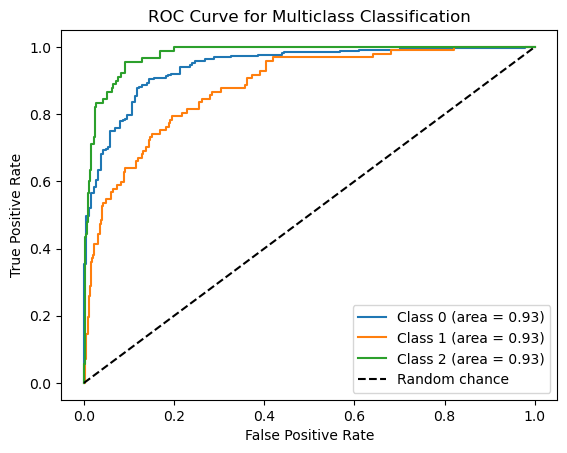

In [88]:
# Predict probabilities for X_test
y_pred_proba = model.predict_proba(X_test)

# Compute ROC AUC score for multiclass
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC AUC Score (OVR): {roc_auc}")

# Plot ROC curve for each class
fpr = {}
tpr = {}
thresholds = {}
n_classes = y_pred_proba.shape[1]  # Number of classes

# Convert y_test to one-vs-rest format (one-hot encoded)
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [101]:
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [106]:
from collections.abc import Sequence
from flask import Flask, request, jsonify, render_template
import joblib
import numpy as np

In [107]:
sentiment_model = joblib.load('sentiment_model.pkl')
emotion_model = joblib.load('emotion_detection_model.pkl')
vectorizer = joblib.load('tfdif_vectorizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Create the Flask app
app = Flask(__name__)

# Route for the chatbot UI (if you want a simple HTML page)
@app.route('/')
def home():
    return render_template('index.html')  # Assuming you have a basic index.html file

# Route to handle chatbot input and provide a response
@app.route('/chat', methods=['POST'])
def chat():
    user_input = request.form['user_input']  # Get the user input from the form
    
    # Preprocess the input text
    user_input_processed = preprocess_text(user_input)  # Use the preprocess_text function
    
    # Vectorize the input for model prediction
    user_input_vectorized = vectorizer.transform([user_input_processed])
    
    # Predict the sentiment
    sentiment_prediction = sentiment_model.predict(user_input_vectorized)
    sentiment_label = 'positive' if sentiment_prediction == 1 else 'negative'
    
    # Predict the emotion (optional)
    emotion_prediction = emotion_model.predict(user_input_vectorized)
    emotion_label = label_encoder.inverse_transform(emotion_prediction)[0]
    
    # Generate the chatbot response (you can customize this logic)
    response = f"Based on your input, I detected a {sentiment_label} sentiment and a {emotion_label} emotion."
    
    # Return the response as JSON or render it on the page
    return jsonify({'response': response})

# Function to preprocess user input (reuse your existing preprocess_text function)
def preprocess_text(text):
    # Preprocessing logic here
    pass

# Run the app
if __name__ == '__main__':
    app.run(port=5001, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/__init__.py", line 7, in <module>
    from .connect import *
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/connect.py", line 12, in <module>
    import jupyter_client
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/__init__.py", line 3, in <module>
    from .asynchronous import AsyncKernelClient
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/__init__.py", line 1, in <module>
    from .client import AsyncKernelClient  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/client.py", line 11, in <module>
    from ..chann

SystemExit: 1

In [ ]:
## Testing if flask runs
# from flask import Flask
# import threading

# # Create Flask app
# app = Flask(__name__)

# @app.route('/')
# def home():
#     return "Hello, Flask is running in Jupyter Notebook!"

# # Function to run the Flask app
# def run_flask_app():
#     app.run(port=5000, debug=True, use_reloader=False)  # use_reloader=False to prevent issues

# # Run Flask app in a separate thread to avoid blocking the notebook
# flask_thread = threading.Thread(target=run_flask_app)
# flask_thread.start()

In [16]:
# # def get_emotion_label(text):
# #     emotions = te.get_emotion(text)
# #     return max(emotions, key=emotions.get)

# # # def get_emojis(text):
# # #     # return " ".join(c for c in text if emoji.is_emoji(c))
# # #     try:
# # #         emoji_list = emoji.emoji_list(text)
# # #         return ' '.join([item['emoji'] for item in emoji_list])
# # #     except:
# # #         return ''



# # # def get_emojis(text):
# # #     return ' '.join([item['emoji'] for item in emoji.emoji_list(text)])
    

# # def custom_cleaning(text):
# #     # if pd.isnull(text):
# #     #     return ''
# #     if not isinstance(text, str):
# #         return str(text)
        
# #     text = text.lower()
# #     # text = get_emojis(text)
# #     text = re.sub(r'http\S+|www.\S+', '', text)
# #     text = re.sub(r'[^a-z\s]', '', text)
# #     return text

# def get_emotion_label(text):
#     emotions = te.get_emotion(text)
#     return max(emotions, key=emotions.get)
    

# def custom_cleaning(text):
#     if not isinstance(text, str):
#         return str(text)
#     text = text.lower()
#     text = re.sub(r'http\S+|www.\S+', '', text)
#     text = re.sub(r'[^a-z\s]', '', text)
#     return text

In [ ]:
# df_copy = df.copy()

# df_copy['cleaned_context'] = df_copy['Context'].apply(custom_cleaning)
# df_copy['cleaned_response'] = df_copy['Response'].apply(custom_cleaning)

# df['context_emotion'] = df['cleaned_context'].apply(get_emotion_label)
# df['response_emotion'] = df['cleaned_response'].apply(get_emotion_label)

# df_copy.head()

In [61]:
print(df[['Context', 'Response']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None
